# Notes

* Data analysis - hypothesis tests, confidence intervals, p-values?
* Parch = parents or children. Is this a useful feature on its own? Before trying to split into parents/children (e.g. by checking for family names), see if parch is statistically significant.
* Sibsp = siblings or spouses
* Would it be useful to create a categorical variable from "Age" that denotes child, teen, young adult, etc.?
* Is it useful to split the data by "Survived" and check for statistical significance between the distributions?
* Besides correlation, are there ways to analyze categorical-categorical relationships? What about categorical-numerical relationships?
    * I think you need to make a distinction b/w ordinal and nominal attributes as well. I don't think you can use correlation for nominal attributes.
* Does it make sense to take the most promising features based on univariate analysis and look more closely at the multivariate analysis?
* Calculate survival rate by age after histogram binning? This is like converting numerical to categorical. Is this useful for feature engineering or just visualization? Statistical testing?
* You don't need to bin for decision trees - they do that already
* Feature selection/feature extraction - yes, you can do EDA/statistical tests, but you also need to check performance in training and evaluation. Feature importance for decision trees, feature permutation tests. Feature selection algorithms. Are there feature extraction algorithms?
    * I think you should spend less time on the statistical testing and instead use EDA to get an intuitive feel for how the features affect the label. Then use training/eval to confirm your intuition and refine your feature selection/feature engineering.

* Create transformation pipeline with the ability to try different data preparation steps, models, and evaluation
    * Using original features
    * Using feature engineering
    * Using different methods of handling missing values
* Dimensionality reduction

# Load libraries and datasets

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score


In [197]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

# First view of the training data

In [201]:
df = df_train
# df = df.astype({"Pclass": "category", "Sex": "category", "Embarked": "category", "Survived": "category"})
# print(df.info())
print(df.columns)
df.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [205]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# df.describe(include="category")

In [206]:
print(f"Number of samples = {df.shape[0]}, number of attributes = {df.shape[1]}\n")
# print(f"Attributes = {df.columns}\n")
print(f"Number of duplicates = {sum(df.duplicated())}\n")
print(f"Percentage of missing values = {round(df.isna().sum().sum() / df.size * 100, 1)}\n")

print("Data Types\n---------------------")
print(df.dtypes)
print("")

print("Missing Values\n---------------------------")
print(df.isna().sum())
print("")

# print(df.isna().sum().sum()

# df.describe()
# df.describe(include="object")


Number of samples = 891, number of attributes = 12

Number of duplicates = 0

Percentage of missing values = 8.1

Data Types
---------------------
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values
---------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64



# Taking natural log

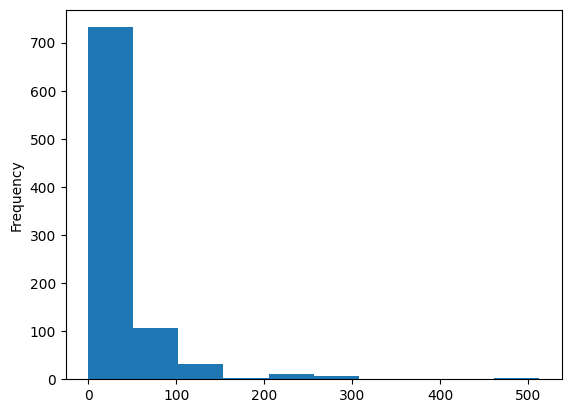

In [26]:
df_num = df.select_dtypes(include=["int64", "float64"]).drop(["PassengerId"], axis="columns").copy()
# df_num.columns
# df_num["Fare"] = np.log(df_num["Fare"].replace(0, np.nan))
df_num["Fare"].plot(kind="hist")
plt.show()
# for col in ["Fare"]:
#     df_num[col] = np.log(df_num[col])
# df_num.head()
# sum(df_num["Fare"] == 0) # 15 people got on for free

# Univariate analysis

## PassengerId - drop

In [207]:
print(np.diff(df["PassengerId"]).min())
print(np.diff(df["PassengerId"]).max())

1
1


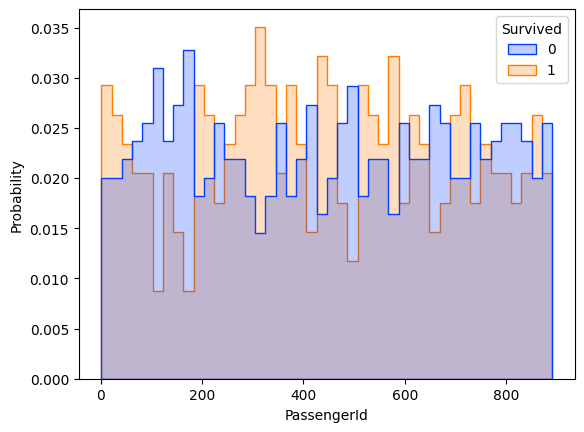

In [211]:
ax = sns.histplot(df, x="PassengerId", hue="Survived", stat="probability", \
                  binwidth=20, common_norm=False, multiple="layer", \
                  element="step", palette="bright")

## Pclass - passthrough

[3 1 2]
int64


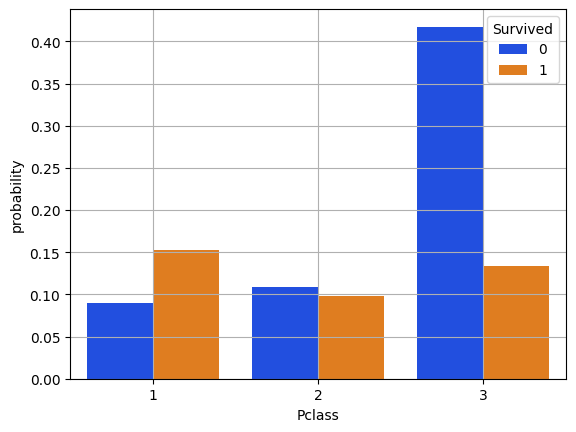

In [216]:
print(df["Pclass"].unique())
print(df["Pclass"].dtype)

ax = sns.countplot(df, x="Pclass", hue="Survived", stat="probability", palette="bright")
ax.grid()

## Sex - ordinal encoding

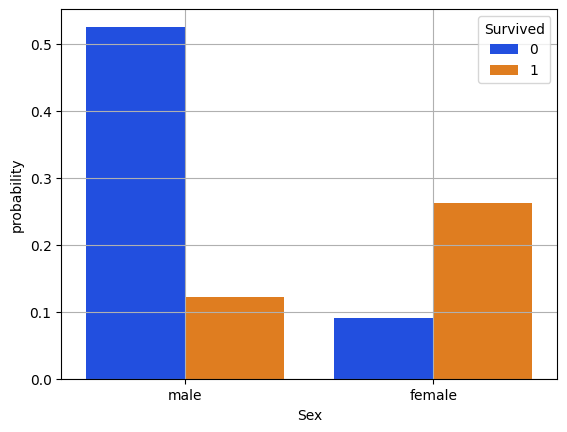

In [245]:
ax = sns.countplot(df, x="Sex", hue="Survived", stat="probability", palette="bright")
ax.grid()

## Age - passthrough

In [251]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

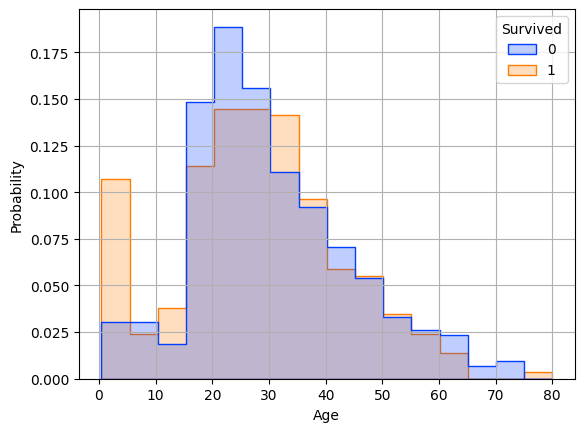

In [249]:
ax = sns.histplot(df, x="Age", hue="Survived", stat="probability", \
                  binwidth=5, common_norm=False, multiple="layer", \
                  element="step", palette="bright", \
                    kde=False, kde_kws={"bw_adjust": 0.5})
ax.grid()

## SibSp, Parch - passthrough, and also add together to create TotalFam

In [261]:
df["SibSp"].value_counts().sort_index()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64

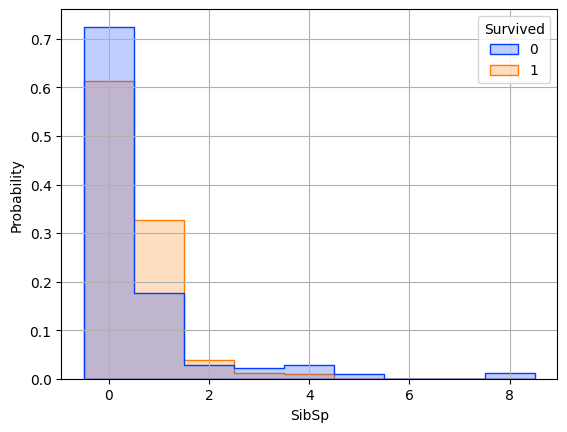

In [252]:
ax = sns.histplot(df, x="SibSp", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", palette="bright", \
                    kde=False, kde_kws={"bw_adjust": 0.5})
ax.grid()

In [260]:
df["Parch"].value_counts().sort_index()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: count, dtype: int64

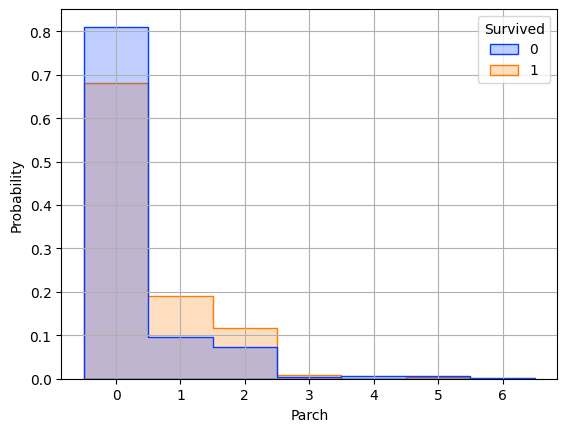

In [258]:
ax = sns.histplot(df, x="Parch", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", palette="bright", \
                    kde=False, kde_kws={"bw_adjust": 0.5})
ax.grid()

In [262]:
df["TotalFam"] = df["SibSp"] + df["Parch"]
df["TotalFam"].value_counts().sort_index()

TotalFam
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

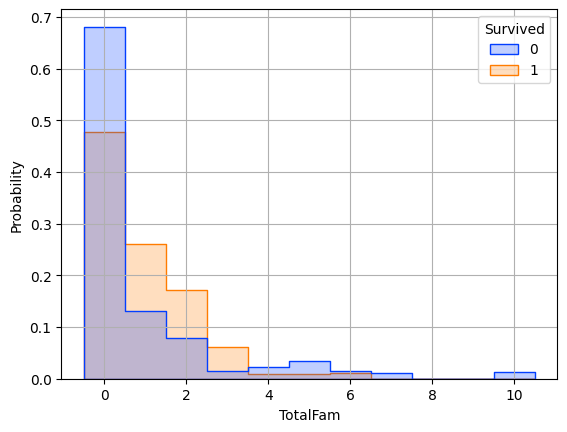

In [263]:
ax = sns.histplot(df, x="TotalFam", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", palette="bright", \
                    kde=False, kde_kws={"bw_adjust": 0.5})
ax.grid()

## Fare - passthrough

In [271]:
df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

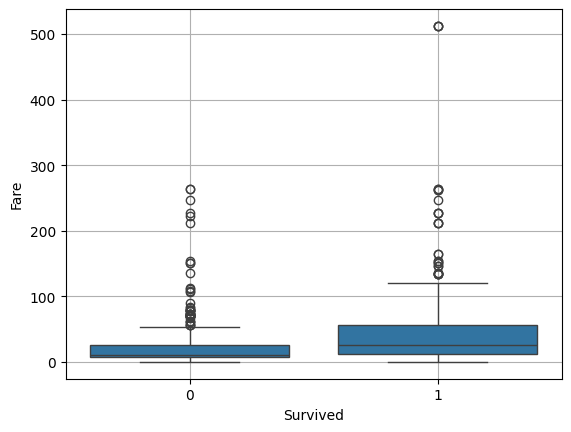

In [279]:
ax = sns.boxplot(df, y="Fare", x="Survived")
ax.grid()

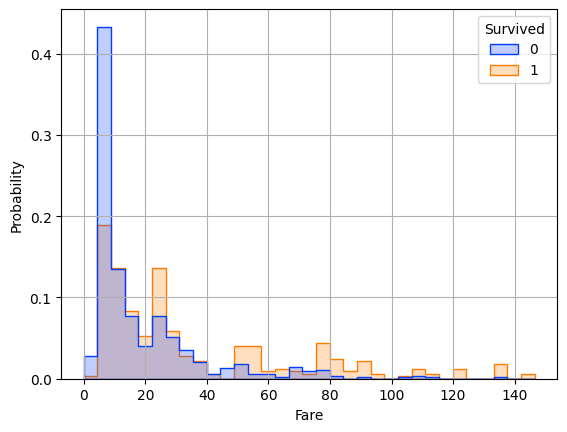

In [284]:
ax = sns.histplot(df.loc[df["Fare"] <= 150], x="Fare", hue="Survived", stat="probability", \
                  common_norm=False, multiple="layer", \
                  element="step", palette="bright", \
                    kde=False, kde_kws={"bw_adjust": 0.5})
ax.grid()

## Name

In [217]:
df["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [286]:
def name_proc(x):
    return x.strip().split(",")[1].strip().split()[0]

titles = df["Name"].map(name_proc)

In [287]:
titles.value_counts()

Name
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Ms.            1
Mme.           1
Don.           1
Lady.          1
Sir.           1
Capt.          1
the            1
Jonkheer.      1
Name: count, dtype: int64

In [244]:
df.loc[titles == "Lady."]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6,A16,C


## Ticket - drop

In [269]:
df["Ticket"].sample(20)

459             371060
252             113514
408             312992
357             237671
384             349227
795              28213
500             315086
176               4133
856              36928
391             350034
568               2686
870             349248
63              347088
310              11767
739             349218
11              113783
157    SOTON/OQ 392090
264             382649
471             315089
661               2623
Name: Ticket, dtype: object

## Cabin

In [295]:
df.loc[df["Cabin"].isna(), "Pclass"].value_counts().sort_index()

Pclass
1     40
2    168
3    479
Name: count, dtype: int64

In [296]:
df.loc[df["Cabin"].notna(), "Pclass"].value_counts().sort_index()

Pclass
1    176
2     16
3     12
Name: count, dtype: int64

In [299]:
def num_cab(x):
    return len(x.strip().split())

numcab = df.loc[df["Cabin"].notna(), "Cabin"].map(num_cab)
numcab.value_counts().sort_index()

Cabin
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [ ]:
df_cab1 = df.loc[(df["Cabin"].notna()) & (numcab == 1)].copy()

def cab_letter(x):
    return x[0]

def cab_number(x):
    return x[1:]

df_cab1["Cabin_Letter"] = df_cab1["Cabin"].map(cab_letter)
# df_cab1["Cabin_Number"] = df_cab1["Cabin"].map(cab_number).astype("int64")

In [ ]:
print(df_cab1["Cabin_Letter"].value_counts())

Cabin_Letter
C    51
B    36
D    32
E    32
A    15
F     9
G     4
T     1
Name: count, dtype: int64
object


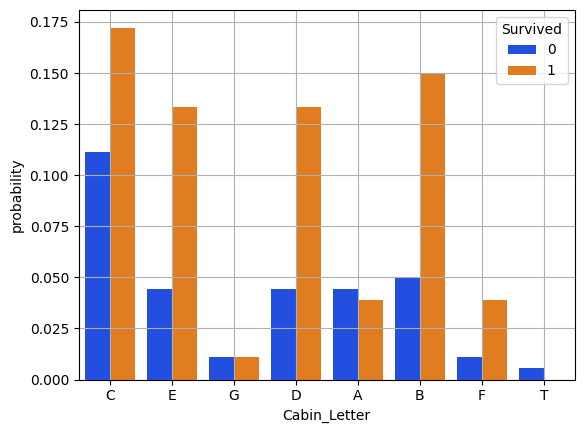

In [321]:
ax = sns.countplot(df_cab1, x="Cabin_Letter", hue="Survived", stat="probability", palette="bright")
ax.grid()

In [306]:
df.loc[(df["Cabin"].notna()) & (numcab > 1), "Cabin"]
df.loc[(df["Cabin"].notna()) & (numcab > 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,5
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S,0
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,5
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C,1
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C,1
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,2
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,3
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C,1
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,3
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,4


## Embarked

## Numerical attributes

In [94]:
df.select_dtypes(include=["int64", "float64"]).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [95]:
df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [118]:
df["Fare"].quantile(0.95)

np.float64(112.07915)

In [134]:
farebins = np.array([-1,10,20,40,60,80,100,120,140,np.inf])

def farecat(x):
    return np.argmax(x <= farebins)-1

In [133]:
df["FareCat"].value_counts()

FareCat
0    336
2    200
1    179
3     54
4     48
8     31
5     21
6     15
7      7
Name: count, dtype: int64

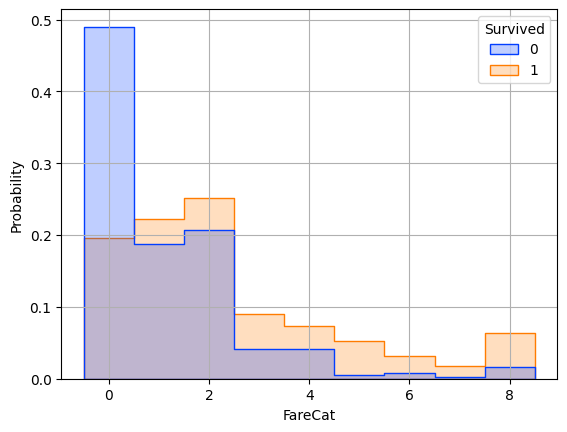

In [135]:
df["FareCat"] = df["Fare"].map(farecat)

# ax = sns.histplot(df.loc[df["Fare"] < 200], x="Fare", hue="Survived", stat="probability", \
#                   binwidth=20, common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.histplot(df.loc[df["Fare"] < 200], x="Fare", hue="Survived", stat="probability", \
#                   bins=[0,10,20,40,60,80,100,120,140,160], common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.histplot(df.loc[df["Fare"] < 200], x="FareScaled", hue="Survived", stat="probability", \
#                   common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.histplot(df, x="Fare", hue="Survived", stat="probability", \
#                   binwidth=10, common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.histplot(df, x="Fare", hue="Survived", stat="probability", \
#                   bins=[0,10,20,40,60,80,100,120,140,550], common_norm=False, multiple="layer", \
#                   element="step", kde=False, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.histplot(df, x="Fare", hue="Survived", stat="probability", \
#                   common_norm=False, multiple="layer", \
#                   element="step", kde=False, kde_kws={"bw_adjust": 1}, palette="bright")

ax = sns.histplot(df, x="FareCat", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=False, kde_kws={"bw_adjust": 1}, palette="bright")

# ax = sns.boxplot(df, x="Fare", hue="Survived")
ax.grid()

In [136]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [149]:
np.clip(df["Age"], a_min=None, a_max=55)

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [150]:
def agecat(x):
    return np.floor(x/5)

df["AgeCat"] = np.floor(np.clip(df["Age"], a_min=None, a_max=55)/5)

df["AgeCat"].value_counts().sort_index()

AgeCat
0.0      40
1.0      22
2.0      16
3.0      86
4.0     114
5.0     106
6.0      95
7.0      72
8.0      48
9.0      41
10.0     32
11.0     42
Name: count, dtype: int64

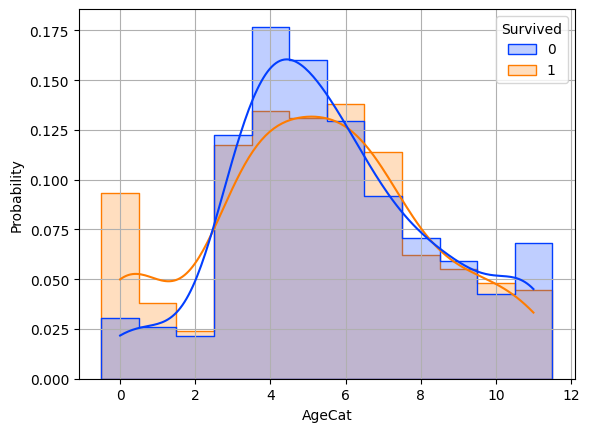

In [152]:
# ax = sns.histplot(df, x="Age", hue="Survived", stat="probability", \
#                   binwidth=5, common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 0.5}, palette="bright")
# ax = sns.histplot(df, x="Age", hue="Survived", stat="probability", \
#                   bins=np.arange(0,60,5), common_norm=False, multiple="layer", \
#                   element="step", kde=True, kde_kws={"bw_adjust": 0.5}, palette="bright")
ax = sns.histplot(df, x="AgeCat", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 1}, palette="bright")


# ax = sns.boxplot(df, x="Age", hue="Survived")
ax.grid()

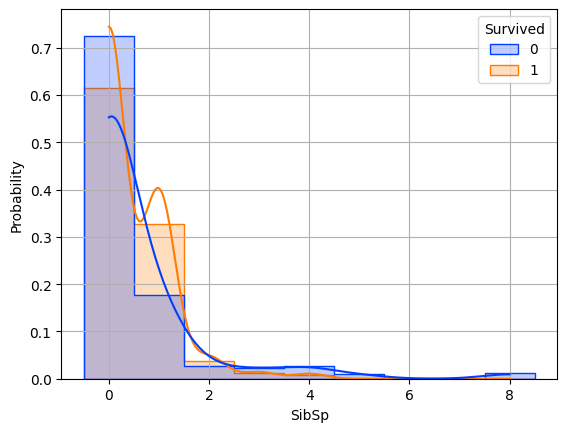

In [102]:
ax = sns.histplot(df, x="SibSp", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 1.5}, palette="bright")
ax.grid()

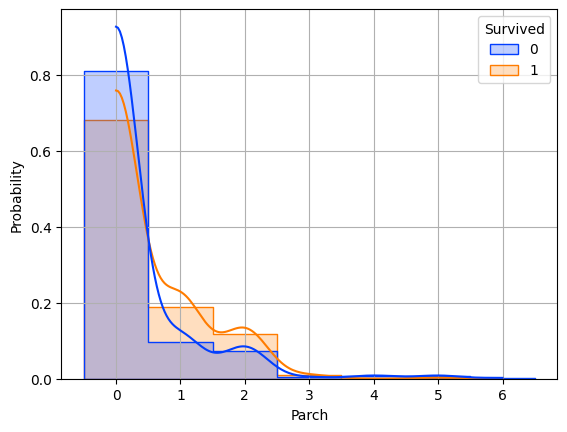

In [103]:
ax = sns.histplot(df, x="Parch", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 1.5}, palette="bright")
ax.grid()

In [155]:
df["TotalFam"] = np.clip(df["Parch"] + df["SibSp"], a_min=0, a_max=4)

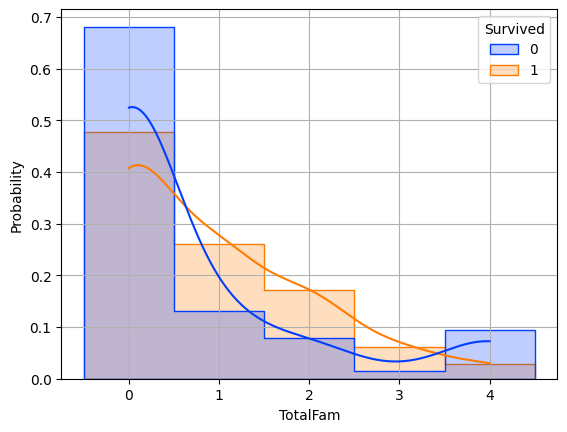

In [156]:
ax = sns.histplot(df, x="TotalFam", hue="Survived", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 1.5}, palette="bright")
ax.grid()

## Categorical attributes

In [ ]:
df["HasFam"] = df["TotalFam"] > 0

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TotalFam', 'HasFam'],
      dtype='object')

In [155]:
def farecat(x):
    if x <= 10:
        return "Fare <= 10"
    else:
        return "10 < Fare"
    # elif 10 < x <= 50:
    #     return "10 < Fare <= 50"
    # else:
    #     return "50 < Fare"
    
df["FareCat"] = df["Fare"].map(farecat)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TotalFam', 'HasFam',
       'FareCat'],
      dtype='object')

In [230]:
# df["AgeBracket"] = pd.Series(range(df.shape[0]), dtype="object")
df["AgeBracket"] = df["Age"].astype("object")
df.loc[df["Age"] <= 5, "AgeBracket"] = "Age <= 5"
df.loc[df["Age"] > 5, "AgeBracket"] = "5 < Age"
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TotalFam', 'HasFam',
       'FareCat', 'AgeMissing', 'AgeBracket'],
      dtype='object')

In [170]:
df["AgeMissing"] = df["Age"].isna()
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TotalFam', 'HasFam',
       'FareCat', 'AgeMissing'],
      dtype='object')

In [177]:
df.select_dtypes(exclude=["int64", "float64"]).columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked',
       'HasFam', 'FareCat', 'AgeMissing', 'AgeBracket'],
      dtype='object')

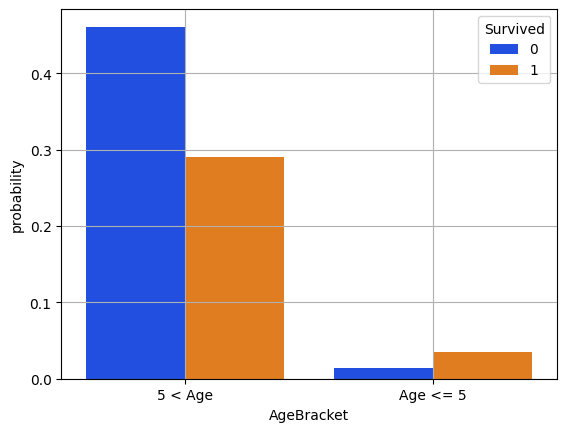

In [231]:
ax = sns.countplot(df, x="AgeBracket", hue="Survived", stat="probability", palette="bright")
ax.grid()

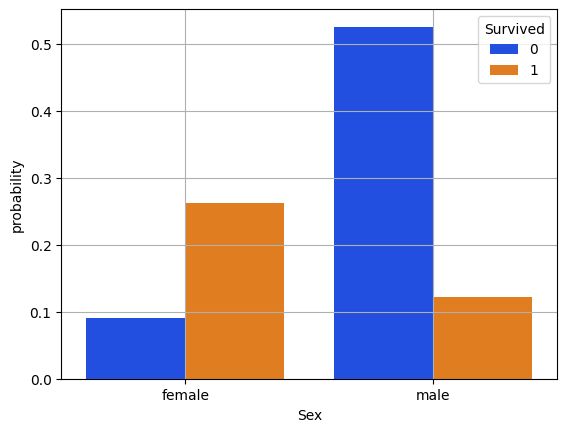

In [157]:
ax = sns.countplot(df, x="Sex", hue="Survived", stat="probability", palette="bright")
ax.grid()

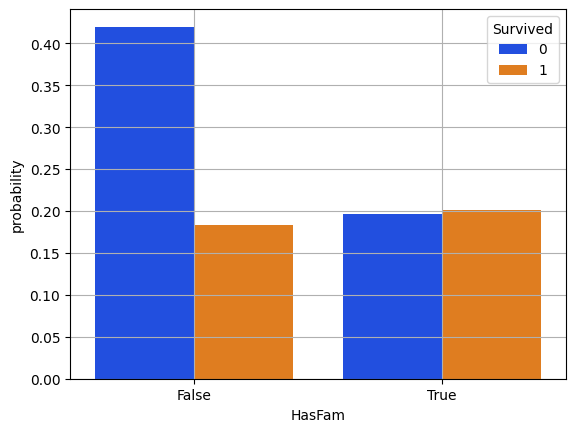

In [141]:
ax = sns.countplot(df, x="HasFam", hue="Survived", stat="probability", palette="bright")
ax.grid()

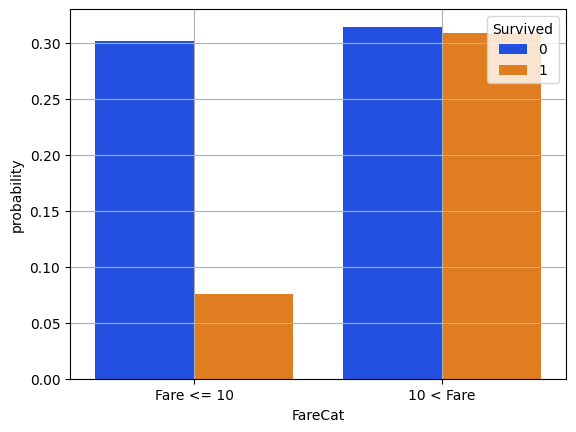

In [156]:
ax = sns.countplot(df, x="FareCat", hue="Survived", stat="probability", palette="bright")
ax.grid()

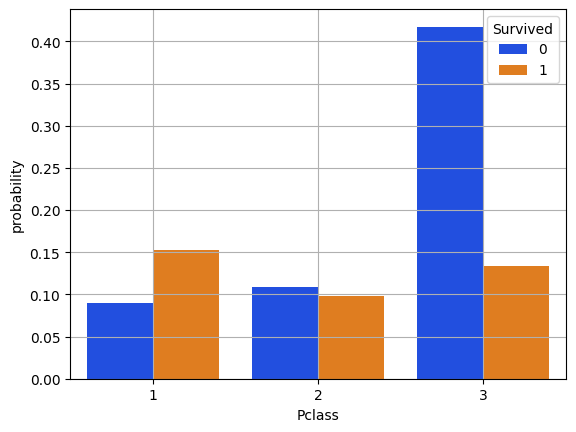

In [158]:
ax = sns.countplot(df, x="Pclass", hue="Survived", stat="probability", palette="bright")
ax.grid()

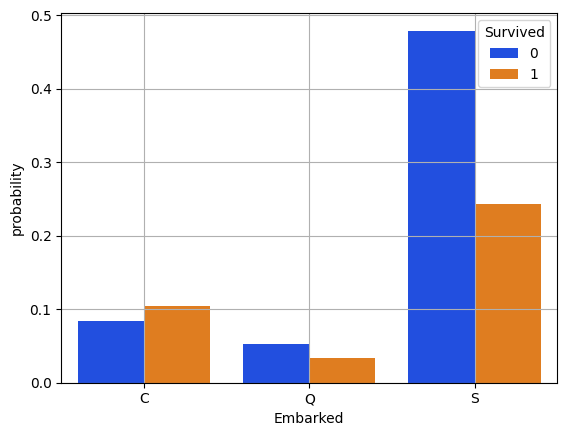

In [ ]:
# I wouldn't expect this to make a difference; this is really where we need statistical testing

ax = sns.countplot(df, x="Embarked", hue="Survived", stat="probability", palette="bright")
ax.grid()

## Cabin regex

In [169]:
df.loc[df["Cabin"].notna()].Pclass.value_counts()

Pclass
1    176
2     16
3     12
Name: count, dtype: int64

In [ ]:
def cabin_re(x):
    x = x.split()
    

x = "B51 B53 B55"

x = "C85"

1              C85
3             C123
6              E46
10              G6
11            C103
          ...     
871            D35
872    B51 B53 B55
879            C50
887            B42
889           C148
Name: Cabin, Length: 204, dtype: object

# Multivariate analysis

# Missing ages

* Is AgeBracket correlated with Pclass, Sex, SibSp, Parch, TotalFam, HasFam, Fare, FareCat?
    * Older people are much more likely to have no other family on board. In fact, if HasFam=False, then the person is older than 5.
    * If Fare <= 10, then Age > 5
    * AgeBracket seems most closely correlated with FareCat and HasFam. What about the underlying numerical relationship?
* Different imputation methods

In [ ]:
corr_mat = df[["Age", "SibSp", "Parch"]].corr(method="spearman")
sns.heatmap(corr_mat, annot=True)

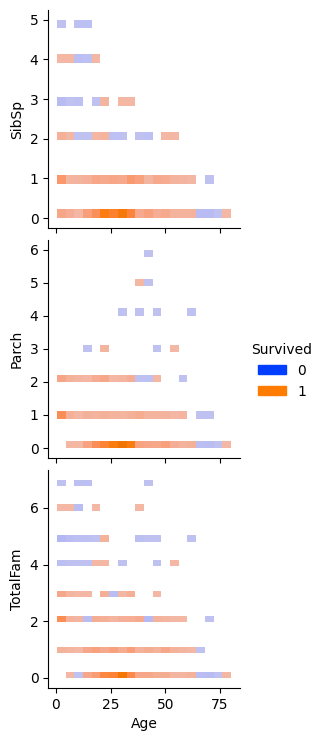

In [257]:
ax = sns.pairplot(df, x_vars="Age", y_vars=["SibSp", "Parch", "TotalFam"], hue="Survived", kind="hist", palette="bright", dropna=True)

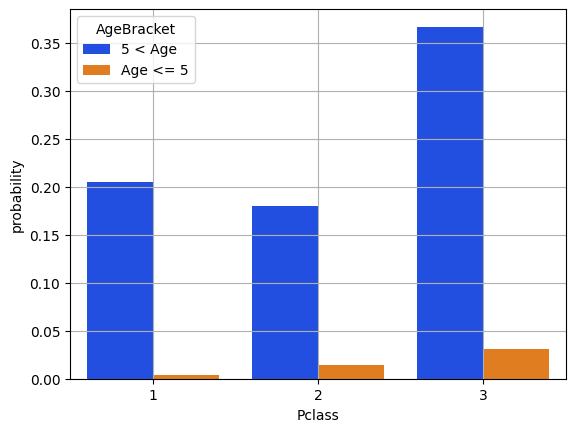

In [234]:
ax = sns.countplot(df, x="Pclass", hue="AgeBracket", stat="probability", palette="bright")
ax.grid()

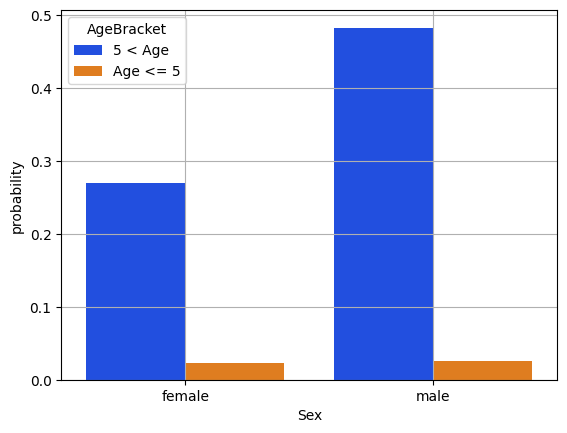

In [235]:
ax = sns.countplot(df, x="Sex", hue="AgeBracket", stat="probability", palette="bright")
ax.grid()

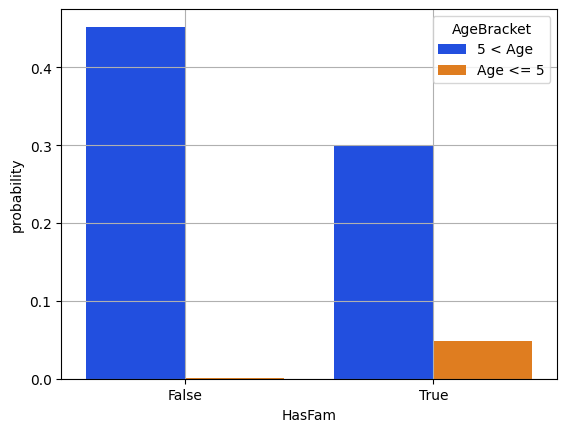

In [241]:
ax = sns.countplot(df, x="HasFam", hue="AgeBracket", stat="probability", palette="bright")
ax.grid()

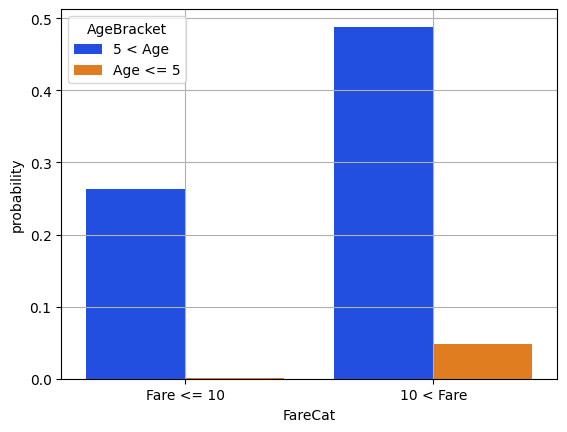

In [242]:
ax = sns.countplot(df, x="FareCat", hue="AgeBracket", stat="probability", palette="bright")
ax.grid()

In [248]:
df.loc[df["AgeBracket"].isna()].FareCat.value_counts()

FareCat
Fare <= 10    100
10 < Fare      77
Name: count, dtype: int64

In [249]:
df.loc[df["AgeBracket"].isna()].HasFam.value_counts()

HasFam
False    133
True      44
Name: count, dtype: int64

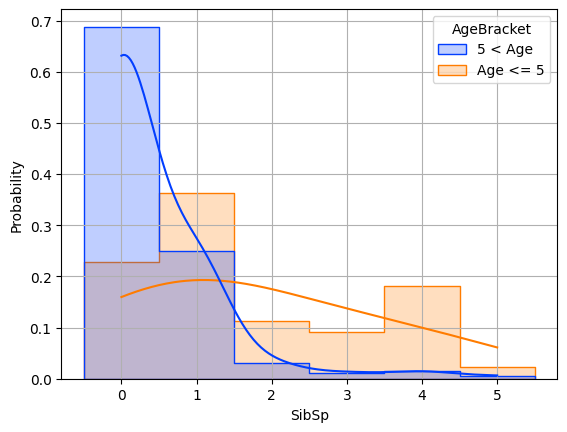

In [263]:
ax = sns.histplot(df, x="SibSp", hue="AgeBracket", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 2}, palette="bright")
ax.grid()

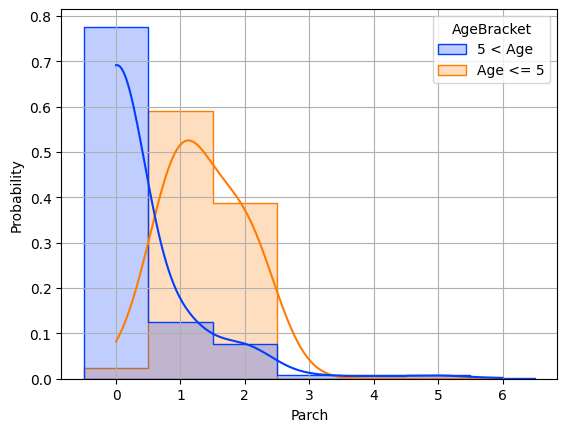

In [262]:
ax = sns.histplot(df, x="Parch", hue="AgeBracket", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 2}, palette="bright")
ax.grid()

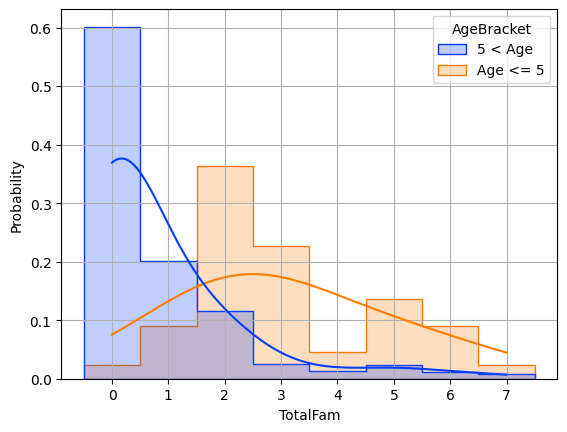

In [240]:
ax = sns.histplot(df, x="TotalFam", hue="AgeBracket", stat="probability", \
                  discrete=True, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 2}, palette="bright")
ax.grid()

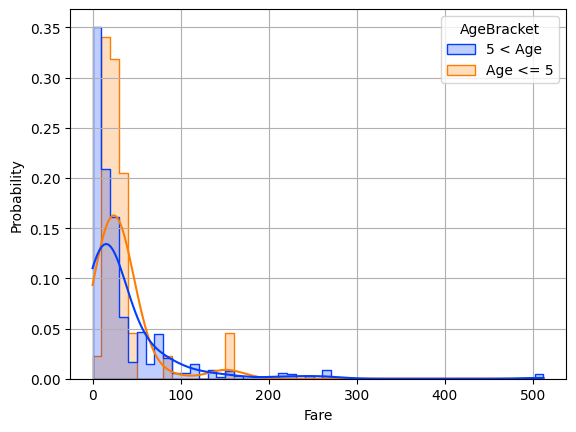

In [247]:
ax = sns.histplot(df, x="Fare", hue="AgeBracket", stat="probability", \
                  binwidth=10, common_norm=False, multiple="layer", \
                  element="step", kde=True, kde_kws={"bw_adjust": 1.5}, palette="bright")
ax.grid()

In [199]:
df.loc[(df["Age"].notna()) & (df["AgeBracket"] == "Age <= 5")].FareCat.value_counts()

FareCat
10 < Fare     43
Fare <= 10     1
Name: count, dtype: int64

In [202]:
df.loc[(df["Age"].notna()) & (df["AgeBracket"] == "5 < Age")].FareCat.value_counts()

FareCat
10 < Fare     435
Fare <= 10    235
Name: count, dtype: int64

In [201]:
df.loc[df["Age"].isna()].FareCat.value_counts()

FareCat
Fare <= 10    100
10 < Fare      77
Name: count, dtype: int64

## Imputation

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

In [176]:
df[["AgeCatScale", "FareCatScale", "TotalFamScale", "PclassScale"]] = MinMaxScaler().fit_transform(df[["AgeCat", "FareCat", "TotalFam", "Pclass"]])

In [193]:
from sklearn.impute import SimpleImputer, KNNImputer

# imp = SimpleImputer(strategy="median")
# tr = imp.fit_transform(df[["AgeCatScale"]])
# df["AgeCatScaleImpute"] = pd.Series(tr.squeeze())

imp = KNNImputer()

# tr = imp.fit_transform(df[["Age", "Fare", "Sex", "Pclass", "TotalFam"]])
tr = imp.fit_transform(df[["AgeCatScale", "FareCatScale", "TotalFamScale", "PclassScale", "SexEnc"]])
imp.get_feature_names_out()

df["AgeCatScaleImpute"] = pd.Series(tr[:, 0])

In [186]:
(tr[:, 0] == np.nan).sum()

np.int64(0)

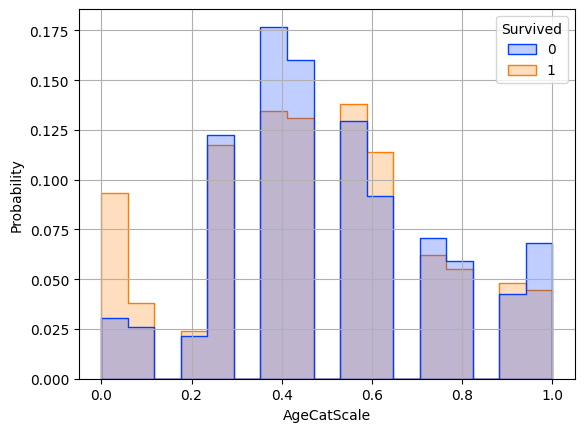

In [181]:
ax = sns.histplot(df, x="AgeCatScale", hue="Survived", stat="probability", \
                  common_norm=False, multiple="layer", \
                  element="step", kde=False, kde_kws={"bw_adjust": 0.5}, palette="bright")
ax.grid()

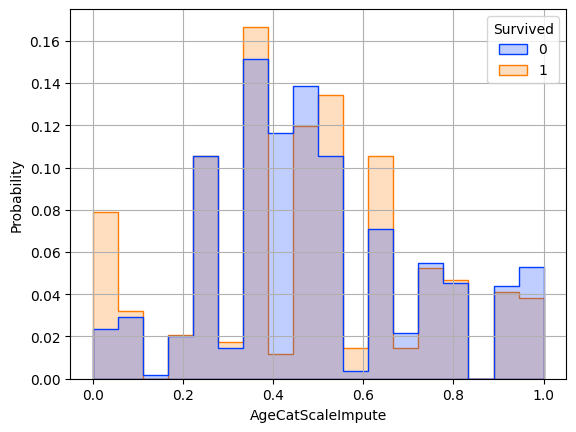

In [194]:
ax = sns.histplot(df, x="AgeCatScaleImpute", hue="Survived", stat="probability", \
                  common_norm=False, multiple="layer", \
                  element="step", kde=False, kde_kws={"bw_adjust": 0.5}, palette="bright")
ax.grid()

array(['Age', 'Fare', 'Pclass', 'TotalFam'], dtype=object)

In [48]:
(tr == np.nan).sum()
df["Age"].isna().sum()

np.int64(177)

# Encoding

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

enc = OneHotEncoder()
enc.fit(df[["Sex"]])


OneHotEncoder()

In [12]:
print(enc.categories_)
enc.transform(df[["Sex"]])

[array(['female', 'male'], dtype=object)]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 891 stored elements and shape (891, 2)>

In [17]:
enc = OrdinalEncoder()
enc.fit(df[["Pclass"]])

OrdinalEncoder()

In [18]:
print(enc.categories_)
enc.transform(df[["Pclass"]])

[array([1, 2, 3])]


array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [1.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],

# Train-val split

In [22]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

X = df.drop("Survived", axis="columns")
y = df["Survived"].copy()

for train_idx, val_idx in skf.split(X, y):
    print(train_idx)
    print(val_idx)
    print('---')

[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57
  58  59  60  61  62  63  64  65  66  67  68  70  71  72  74  75  76  77
  78  79  80  81  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 109 110 111 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 153 155 156 157
 158 159 160 161 162 163 164 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 182 183 185 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 214 215 216
 217 219 220 221 222 223 224 225 226 227 230 231 233 234 235 236 237 238
 239 240 241 242 243 246 247 248 249 250 251 252 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 273 27

# Pipeline

In [24]:
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = RandomForestClassifier(class_weight="balanced")
# model = RandomForestClassifier(class_weight="balanced_subsample")
# model = HistGradientBoostingClassifier()

data_pipe = ColumnTransformer([
    ("scaler_only", StandardScaler(), ["Fare", "Age", "SibSp", "Parch"]),
    ("ordinal_encoder", OrdinalEncoder(), ["Sex"]),
    ("onehot_encoder", OneHotEncoder(), ["Embarked", "Pclass"]),
    # ("labels", "passthrough", ["Survived"])
])

ml_pipe = Pipeline([
    ("preprocess", data_pipe),
    ("model", model)
])

In [28]:
dir(ml_pipe.named_steps.model)

['_BaseDecisionTree__metadata_request__predict',
 '_DecisionTreeClassifier__metadata_request__fit',
 '_DecisionTreeClassifier__metadata_request__predict_proba',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_missing_values_in_feature_mask',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_fit',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags'